In [1]:
import numpy as np
import pandas as pd
import random
import copy
import functools
import time

from matplotlib import pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True)
X, y = data['data'], data['target']

display(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


### Вспомогательный класс для построения дерева принятия решений. Подробнее смотри файл DecisionTreeRegressor

In [3]:
class Node:
    """Вспомогательный класс для реализации структуры дерева"""
    def __init__(self):
        self.feature = None
        self.value_split = None
        self.value_leaf = None
        self.side = None
        self.left = None
        self.right = None

class MyTreeReg:
     """
    Дерево принятия решений, регрессия

    Параметры:
    max_depth : int
        Максимальная глубина дерева, by default 5.
    min_samples_split : int
        Кол-во объектов в листе, чтобы его можно было разбить и превратить в узел by default 2.    
    max_leafs : int
        Максимальное количество листьев у дерева by default 20.
    bins: int, optional
        Количество бинов, разбивающее фичи при обучении, by default None.
    ----------
    Методы:
    fit : построение регрессора дерева принятия решений из обучающего набора.
    predict: получение прогнозируемых значений регрессии для датасета Х.
    print_tree: отрисовка обученного дерева
    feature_importances: получение массива важности фичей
    """

     def __init__(self, 
                 max_depth: int = 5, 
                 min_samples_split: int = 2, 
                 max_leafs: int = 20, 
                 bins: int | None = None) -> None:        
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leafs = max_leafs
        self.bins = bins
        if self.max_leafs <= 1:
            self.max_leafs = 2
            self.max_depth = 1
        self.leafs_cnt = 1
        # добавление словаря для подсчета feature importance
        self.fi = {}

     def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """Обучение дерева принятия решений

        Parameters
        ----------
        X : pd.DataFrame
            Все фичи
        y : pd.Series
            Целевая переменная
        """
        X = pd.DataFrame(X)
        y = pd.Series(y)
        self.tree = None
        self.split_values = {}
        self.fi = {col: 0 for col in X.columns}
        
        # построение дерева
        def create_tree(root, X_root: pd.DataFrame, y_root: pd.Series, side: str = 'root', depth: int = 0) -> None:
            if root is None:
                root = Node()
            # проверка на корень
            y_root_unique_size = len(y_root.unique())
            if y_root_unique_size == 0 or y_root_unique_size == 1 or \
              depth >= self.max_depth or len(y_root) < self.min_samples_split \
              or (self.leafs_cnt > 1 and self.leafs_cnt >= self.max_leafs):
                root.side = side
                root.value_leaf = y_root.mean()
                return root
            
            # лучшее разбиение
            col_name, split_value, gain = self.__get_best_split(X_root, y_root)
            
            #обновление словаря feature importance
            self.fi[col_name] += gain * len(y_root) / len(y)
            
            #разбиение датасета
            X_left = X_root[X_root[col_name] <= split_value]
            y_left = y_root[X_root[col_name] <= split_value]

            X_right = X_root[X_root[col_name] > split_value]
            y_right = y_root[X_root[col_name] > split_value]

            if len(X_left) == 0 or len(X_right) == 0:
                root.side = side
                root.value_leaf = y_root.mean()
                return root

            root.feature = col_name
            root.value_split = split_value
            self.leafs_cnt += 1
            
            #рекурсивное развитие дерева
            root.left = create_tree(root.left, X_left, y_left, 'left', depth + 1)
            root.right = create_tree(root.right, X_right, y_right, 'right', depth + 1)

            return root

        self.tree = create_tree(self.tree, X, y)

     def predict(self, X: pd.DataFrame) -> np.array:
        """Выдача предсказаний моделью

        Parameters
        ----------
        X : pd.DataFrame
            Матрица фичей
        """
        y_pred = []
        for _, row in X.iterrows():
            node = self.tree
            while node.feature:
                if row[node.feature] <= node.value_split:
                    node = node.left
                else:
                    node = node.right
            y_pred.append(node.value_leaf)
        return np.array(y_pred)

     def print_tree(self, node=None, depth=0):
        """Отрисовка полученного дерева принятия решений"""
        if node is None:
            node = self.tree
        if node.feature is not None:
            print(f"{'    ' * depth}{node.feature} > {node.value_split}")
            if node.left is not None:
                self.print_tree(node.left, depth + 1)
            if node.right is not None:
                self.print_tree(node.right, depth + 1)
        else:
            print(f"{'    ' * depth}{node.side} = {node.value_leaf}")
            
     def feature_importances(self) -> np.array:
        """Получение матрицы относительной важности фичей"""
        arr = np.array([i for i in self.fi.values()])
        t_min = 0
        t_max = arr.max() / arr.sum()
        norm_arr = []
        diff = t_max - t_min
        diff_arr = max(arr) - min(arr)    
        for i in arr:
            temp = (((i - min(arr))*diff)/diff_arr) + t_min
            norm_arr.append(temp)
        return np.array(norm_arr)
            
     #Вспомогательная функция. Ищет наилучшее разбиение датасета   
     def __get_best_split(self, X, y):
        mse_0 = self.__mse(y)

        col_name = None
        split_value = None
        gain = -float('inf')

        for col in X.columns:
            if not (col in self.split_values.keys()):
                x_unique_values = np.unique(X[col])
                if self.bins is None or len(x_unique_values) - 1 < self.bins:
                    self.split_values[col] = np.array([(x_unique_values[i - 1] + \
                    x_unique_values[i]) / 2 for i in range(1, len(x_unique_values))])
                else:
                    _, self.split_values[col] = np.histogram(X[col], bins=self.bins)

            for split_value_i in self.split_values[col]:
                mask = X[col] <= split_value_i
                left_split, right_split = y[mask], y[~mask]

                mse_left = self.__mse(left_split)
                mse_right = self.__mse(right_split)

                weight_left = len(left_split) / len(y)
                weight_right = len(right_split) / len(y)

                mse_i = weight_left * mse_left + weight_right * mse_right

                gain_i = mse_0 - mse_i
                if gain < gain_i:
                    col_name = col
                    split_value = split_value_i
                    gain = gain_i

        return col_name, split_value, gain

     #Функция, вычисляющая MSE
     def __mse(self, t):
        t_mean = np.mean(t)
        return ((t - t_mean) ** 2).mean()

     def __str__(self):
        return f"MyTreeReg class: max_depth={self.max_depth}, min_samples_split={self.min_samples_split}, max_leafs={self.max_leafs}"

### Вспомогательный класс для построения линейной регрессии. Подробнее смотри файл LinearRegression

In [4]:
class MyLineReg:    
    """
    Линейная регрессия

    Parameters
    ----------
    n_iter : int, optional
        Количество шагов градиентного спуска, by default 100
    learning_rate : float, optional
        Коэффициент скорости обучения градиентного спуска.
        Если на вход пришла lambda-функция, то learning_rate вычисляется на каждом шаге на основе переданной функцией
    weights : np.ndarray, optional
        Веса модели
    metric : str, optional
        Метрика, которая будет вычисляться параллельно с функцией потерь.
        Принимает одно из следующих значений: mae, mse, rmse, mape, r2
    reg : str, optional
        Вид регуляризации. Принимает одно из следующих значений: l1, l2, elasticnet, by default None
    l1_coef : float, optional
        Коэффициент L1 регуляризации. Принимает значения от 0.0 до 1.0, by default 0
    l2_coef : float, optional
        Коэффициент L2 регуляризации. Принимает значения от 0.0 до 1.0, by default 0
    sgd_sample : Union[int, float], optional
        Количество образцов, которое будет использоваться на каждой итерации обучения.
        Может принимать целые числа, либо дробные от 0.0 до 1.0, by default None
    random_state : int, optional
        Сид для воспроизводимости результата, by default 42
    
    """
    
    @staticmethod
    def timer(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            val = func(*args, **kwargs)
            end = time.perf_counter()
            work_time = end - start
            print(f'Время выполнения {func.__name__}: {round(work_time, 4)} сек.')
            return val
        return wrapper
    
    def __init__(self, 
                 n_iter: int = 100, 
                 learning_rate: float = 0.1,             
                 metric: str | None = None, 
                 reg: str | None = None, 
                 l1_coef: float = 0.0, 
                 l2_coef: float = 0.0, 
                 random_state: int = 42, 
                 sgd_sample: str | None = None) -> None:
                
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.weights = None
        self.metric = metric
        self.best_score = None
        self.metrics = {
            'mae':  lambda y, y_pred: np.mean(np.abs(y - y_pred)),
            'mse':  lambda y, y_pred: np.mean((y - y_pred) ** 2),
            'rmse': lambda y, y_pred: np.sqrt(np.mean((y - y_pred) ** 2)),
            'mape': lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100,
            'r2':   lambda y, y_pred: 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
        }
        self.reg = reg
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.sgd_sample = sgd_sample 
        self.random_state = random_state
    
    def fit(self, X: pd.DataFrame, y: pd.Series, verbose: int | bool = False) -> None:        
        """Обучение линейной регрессии

        Parameters
        ----------
        X : pd.DataFrame
            Все фичи
        y : pd.Series
            Целевая переменная
        verbose : int, optional
            Указывает через сколько итераций градиентного спуска будет выводиться лог
        """
        
        random.seed(self.random_state)
        n_samples, n_features = X.shape
        X = X.copy()
        ones = np.ones(n_samples)
        X.insert(0, 'x_0', ones)
        
        self.weights = np.ones(n_features + 1)

        for iter in range(1, self.n_iter + 1):
            
            #разделение трейна на батчи
            if isinstance(self.sgd_sample, float):
                sample_rows_idx = random.sample(range(X.shape[0]), round(X.shape[0] * self.sgd_sample))                
            if isinstance(self.sgd_sample, int):
                sample_rows_idx = random.sample(range(X.shape[0]), self.sgd_sample)            
            if not self.sgd_sample:
                sample_rows_idx = range(X.shape[0])                                                
            X_batch = X.iloc[sample_rows_idx]
            y_batch = y.iloc[sample_rows_idx]
            
            #вычисление лосса и предсказания
            y_pred = X @ self.weights
            loss = np.sum((y - y_pred) ** 2) / n_samples            
            
            #учет регулиризации
            if self.reg == 'l1' or self.reg == 'elasticnet':
                loss += self.l1_coef * np.sum(np.abs(self.weights))
            if self.reg == 'l2' or self.reg == 'elasticnet':
                loss += self.l2_coef * np.sum(self.weights ** 2)
            
            #расчеты скорости градиентного спуска и весов
            if not isinstance(self.learning_rate, (float, int)):
                lr = self.learning_rate(iter + 1)
                self.weights -= lr * self.__calc_grad(X_batch, y_batch)
            else:
                self.weights -= self.learning_rate * self.__calc_grad(X_batch, y_batch)
                
            #расчет последнего значения метрики
            if self.metric:
                self.best_score = self.metrics[self.metric](y, y_pred)
            
            #вывод лога
            if verbose and iter % verbose == 0:
                print(f"{iter if iter != 0 else 'start'} | loss: {loss}", f"| {self.metric}: {self.best_score}" if self.metric else '')

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """Выдача предсказаний моделью

        Parameters
        ----------
        X : pd.DataFrame
            Матрица фичей
        """
        
        X = X.copy()
        ones = np.ones(X.shape[0])
        X.insert(0, 'x_0', ones)
        return X @ self.weights
    
    def __calc_grad(self, X: pd.DataFrame, y: pd.Series) -> float:
        n_samples, _ = X.shape
        grad = 2 / n_samples * (X.T @ (X @ self.weights - y))        
        if self.reg:
            if self.reg == 'l1' or self.reg == 'elasticnet':
                grad += self.l1_coef * np.sign(self.weights)
            if self.reg == 'l2' or self.reg == 'elasticnet':
                grad += self.l2_coef * 2 * self.weights        
        return grad
    
    def get_coef(self) -> pd.Series:
        """Возвращает значений весов"""
        return self.weights[1:]

    def get_best_score(self) -> float:
        """Возвращает последнее значение метрики"""
        return self.best_score
        
    def __str__(self) -> str:
        return f"MyLineReg class: n_iter={self.n_iter}, learning_rate={self.learning_rate}" + \
            f' metric={self.metric}, reg={self.reg}, sgd_sample={self.sgd_sample}'
    
    def __repr__(self) -> str:
        return f'MyLineReg class: {self.__dict__}'
    


### Вспомогательный класс для построения KNN. Подробнее смотри файл KNN

In [5]:
class MyKNNReg:
     """
    Метод ближащих соседей (регрессия)

    Parameters
    ----------
    k : int
        Количество ближайших соседей, by default 3
    metric : str, optional
        Метрика, которая будет вычисляться параллельно с функцией потерь.
        Принимает одно из следующих значений: euclidean, chebyshev, manhattan, cosine
    weights : np.ndarray, optional
        Веса модели
    metric : str, optional
        Метрика, которая будет вычисляться параллельно с функцией потерь.
        Принимает одно из следующих значений: mae, mse, rmse, mape, r2    
    """
    
     def __init__(self, k: int = 5, metric: str = 'euclidean', weight: np.array = 'uniform') -> None:
        self.k = k
        self.train_size = None
        self.metric = metric
        self.metrics = {
            'euclidean': lambda test, train: np.sqrt(np.sum((test - train) ** 2, axis=-1)),
            'chebyshev': lambda test, train: np.max(np.abs(test - train), axis=-1),
            'manhattan':  lambda test, train: np.sum(np.abs(test - train), axis=-1),
            'cosine':  lambda test, train: 1 - np.sum(test * train, axis=-1) / (np.sqrt(np.sum(test ** 2, axis=-1)) * (np.sqrt(np.sum(train ** 2, axis=-1))))
         }
        self.weight = weight
        
     def __repr__(self) -> str:
        return f"MyKNNClf class: k={self.k}"

     def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """Обучение KNN

        Parameters
        ----------
        X : pd.DataFrame
            Все фичи
        y : pd.Series
            Целевая переменная
        """
        self.X = X.to_numpy()
        self.y = y.to_numpy()
        self.train_size = self.X.shape        

     def predict(self, X: pd.DataFrame) -> np.array:
        """Выдача предсказаных значений моделью

        Parameters
        ----------
        X : pd.DataFrame
            Матрица фичей
        """
        train = np.expand_dims(self.X, axis=0)
        test = np.expand_dims(X.to_numpy(), axis=1)
        distances = self.metrics[self.metric](train, test)
        indx = np.argsort(distances)[:, :self.k]
        dist = np.sort(distances)[:, :self.k]
        
        return self.__get_proba(indx, distances) 
    
     def __get_proba(self, indx: int, dist: float):
        proba_formulas = {
            "uniform": np.mean(self.y[indx], axis=1),
            "rank": np.sum(self.y[indx] / np.arange(1, self.k + 1), axis=1) / np.sum(1 / np.arange(1, self.k + 1)),
           } 
        
        return proba_formulas[self.weight]


In [6]:
class MyBaggingReg:
    
    @staticmethod
    def timer(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            val = func(*args, **kwargs)
            end = time.perf_counter()
            work_time = end - start
            print(f'Время выполнения {func.__name__}: {round(work_time, 4)} сек.')
            return val
        return wrapper   
        
    def __init__(self, estimator = None, n_estimators: int = 10, max_samples: float = 1.0, oob_score: str = None, random_state: int = 42):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples if 0.0 <= max_samples <= 1.0 else 1.0
        self.random_state = random_state
        self.estimators = []
        
        self.oob_score = oob_score
        self.metrics = {
            'mae':  lambda y, y_pred: np.mean(np.abs(y - y_pred)),
            'mse':  lambda y, y_pred: np.mean((y - y_pred) ** 2),
            'rmse': lambda y, y_pred: np.sqrt(np.mean((y - y_pred) ** 2)),
            'mape': lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100,
            'r2':   lambda y, y_pred: 1 - ((y - y_pred) ** 2).mean() / ((y - y.mean()) ** 2).mean()
        }
        self.oob_score_ = 0
        self.oob_samples_table = []

    def __str__(self):
        # getting dict() of all attributes
        atr = self.__dict__
        res = ''.join([i + '=' + str(atr[i]) + ',' + ' ' for i in atr])[:-2]
        return 'MyBaggingReg class: ' + res
    
    @timer
    def fit(self, X, y):
        random.seed(self.random_state)
        rows_num_list = list(X.index)
        rows_smpl_cnt = round(self.max_samples * X.shape[0])       
        sample_rows_idx = [random.choices(rows_num_list, k=rows_smpl_cnt) for i in range(self.n_estimators)]
        for i in range(self.n_estimators):     
            X_bootstrap = X.loc[sample_rows_idx[i]]
            y_bootstrap = y.loc[sample_rows_idx[i]]
            model = copy.deepcopy(self.estimator)
            model.fit(X_bootstrap, y_bootstrap)
            self.estimators.append(model)
            
            #вычисление OOB
            if self.oob_score:                             
                rows_oob = [i for i in rows_num_list if i not in sample_rows_idx]                
                X_oob = X.loc[rows_oob]                
                y_oob_test = y.loc[rows_oob]
                pred_oob = model.predict(X_oob)
                
                self.oob_score_ = self.metrics[self.oob_score](y_oob_test, pred_oob)
                self.oob_samples_table.append(self.oob_score_)
        if self.oob_score: 
            self.oob_score_ = np.mean(np.array(self.oob_samples_table))
    @timer       
    def predict(self, X):
        result = []
        X = X.copy()
        prophecy = np.array([model.predict(X) for model in self.estimators])
        return prophecy.sum(axis=0) / len(self.estimators)

### Деревья


In [7]:
my_bagging_tree = MyBaggingReg(estimator=MyTreeReg(bins=5), n_estimators=25, oob_score='mse')
my_bagging_tree.fit(X_train, y_train)
y_pred = my_bagging_tree.predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred)}')
print(f'OOB score {my_bagging_tree.oob_score.upper()}: {my_bagging_tree.oob_score_}')

Время выполнения fit: 8.6811 сек.
Время выполнения predict: 0.0452 сек.
Значение MSE: 3043.6794015920186
OOB score MSE: 3392.131867289613


In [8]:
%%capture test
mse_list = []
n_estimators = []
for i in range(1, 21):
    model = MyBaggingReg(estimator=MyTreeReg(bins=10), n_estimators=i, oob_score='mse')
    model.fit(X_train, y_train)
    y_pred_tree = model.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred_tree))
    n_estimators.append(i)

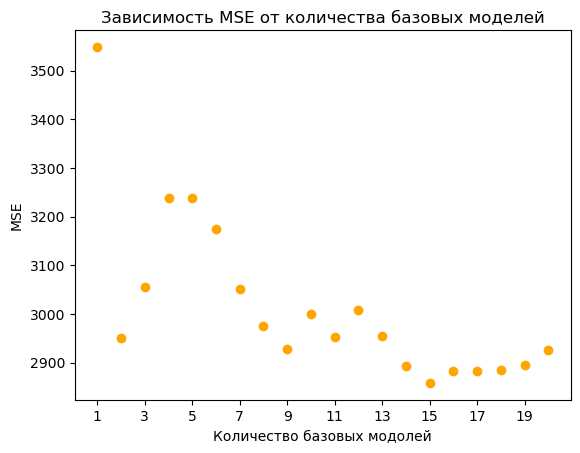

In [9]:
plt.title('Зависимость MSE от количества базовых моделей')
plt.scatter(n_estimators, mse_list, color='orange')
plt.xlabel('Количество базовых модолей')
plt.ylabel('MSE')
plt.xticks([i for i in range(1, 20, 2)])
plt.show()

In [10]:
sklearn_bagging_tree = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=25, oob_score=True)
sklearn_bagging_tree.fit(X_train, y_train)
y_pred_sklear = sklearn_bagging_tree.predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred_sklear)}')
print(f'OOB score: {sklearn_bagging_tree.oob_score_}')

Значение MSE: 3091.2212314606745
OOB score: 0.3999905183896051


In [11]:
mse_sklearn_list = []
n_estimators_sklearn = []
for i in range(1, 50):
    model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    y_pred_tree = model.predict(X_test)
    mse_sklearn_list.append(mean_squared_error(y_test, y_pred_tree))
    n_estimators_sklearn.append(i)

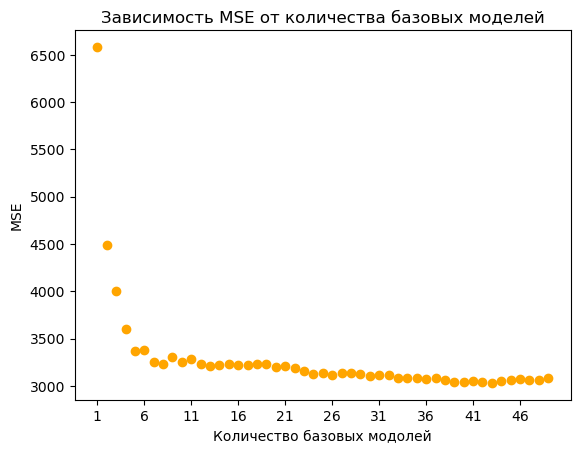

In [12]:
plt.title('Зависимость MSE от количества базовых моделей')
plt.scatter(n_estimators_sklearn, mse_sklearn_list, color='orange')
plt.xlabel('Количество базовых модолей')
plt.ylabel('MSE')
plt.xticks([i for i in range(1, 50, 5)])
plt.show()

### KNN

In [13]:
my_bagging_KNN = MyBaggingReg(estimator=MyKNNReg(), n_estimators=25, oob_score='mse')
my_bagging_KNN.fit(X_train, y_train)
y_pred = my_bagging_KNN.predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred)}')
print(f'OOB score {my_bagging_KNN.oob_score.upper()}: {my_bagging_KNN.oob_score_}')

Время выполнения fit: 0.3809 сек.
Время выполнения predict: 0.0867 сек.
Значение MSE: 2951.285226426966
OOB score MSE: 3107.22635694051


In [14]:
%%capture test
mse_list = []
n_estimators = []
for i in range(1, 41):
    model = MyBaggingReg(estimator=MyKNNReg(), n_estimators=i)
    model.fit(X_train, y_train)
    y_pred_tree = model.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred_tree))
    n_estimators.append(i)

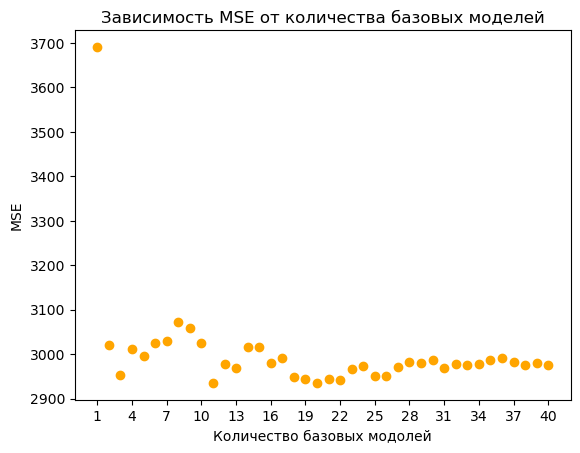

In [15]:
plt.title('Зависимость MSE от количества базовых моделей')
plt.scatter(n_estimators, mse_list, color='orange')
plt.xlabel('Количество базовых модолей')
plt.ylabel('MSE')
plt.xticks([i for i in range(1, 42, 3)])
plt.show()

In [16]:
sklearn_bagging_tree = BaggingRegressor(estimator=KNeighborsRegressor(n_neighbors=5), n_estimators=25, oob_score=True)
sklearn_bagging_tree.fit(X_train, y_train)
y_pred_sklear = sklearn_bagging_tree.predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred_sklear)}')
print(f'OOB score: {sklearn_bagging_tree.oob_score_}')

Значение MSE: 2978.7206069213485
OOB score: 0.3873549697512132


In [17]:
mse_sklearn_list = []
n_estimators_sklearn = []
for i in range(1, 41):
    model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    y_pred_tree = model.predict(X_test)
    mse_sklearn_list.append(mean_squared_error(y_test, y_pred_tree))
    n_estimators_sklearn.append(i)

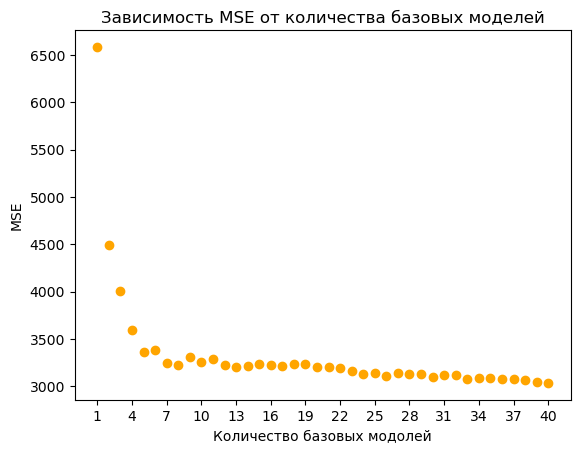

In [18]:
plt.title('Зависимость MSE от количества базовых моделей')
plt.scatter(n_estimators_sklearn, mse_sklearn_list, color='orange')
plt.xlabel('Количество базовых модолей')
plt.ylabel('MSE')
plt.xticks([i for i in range(1, 42, 3)])
plt.show()

### Linear Reg

In [19]:
my_bagging_line = MyBaggingReg(estimator=MyLineReg(), n_estimators=25, oob_score='mse')
my_bagging_line.fit(X_train, y_train)
y_pred = my_bagging_line.predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred)}')
print(f'OOB score {my_bagging_line.oob_score.upper()}: {my_bagging_line.oob_score_}')

Время выполнения fit: 2.4527 сек.
Время выполнения predict: 0.0079 сек.
Значение MSE: 4701.572201307398
OOB score MSE: 5390.705954353066


In [20]:
%%capture test
mse_list = []
n_estimators = []
for i in range(1, 41):
    model = MyBaggingReg(estimator=MyLineReg(), n_estimators=i, oob_score='mse')
    model.fit(X_train, y_train)
    y_pred_tree = model.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred_tree))
    n_estimators.append(i)

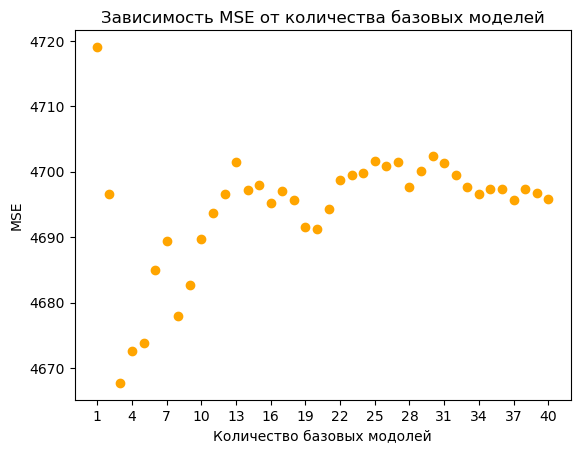

In [21]:
plt.title('Зависимость MSE от количества базовых моделей')
plt.scatter(n_estimators, mse_list, color='orange')
plt.xlabel('Количество базовых модолей')
plt.ylabel('MSE')
plt.xticks([i for i in range(1, 41, 3)])
plt.show()

In [22]:
sklearn_bagging_line = BaggingRegressor(estimator=LinearRegression(), n_estimators=25, oob_score=True)
sklearn_bagging_line.fit(X_train, y_train)
y_pred_sklearn_line = sklearn_bagging_line.predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred_sklearn_line)}')
print(f'OOB score: {sklearn_bagging_line.oob_score_}')

Значение MSE: 2945.6386480364035
OOB score: 0.500007615661795


In [23]:
mse_sklearn_list = []
n_estimators_sklearn = []
for i in range(1, 100):
    model = BaggingRegressor(estimator=LinearRegression(), n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    y_pred_tree = model.predict(X_test)
    mse_sklearn_list.append(mean_squared_error(y_test, y_pred_tree))
    n_estimators_sklearn.append(i)

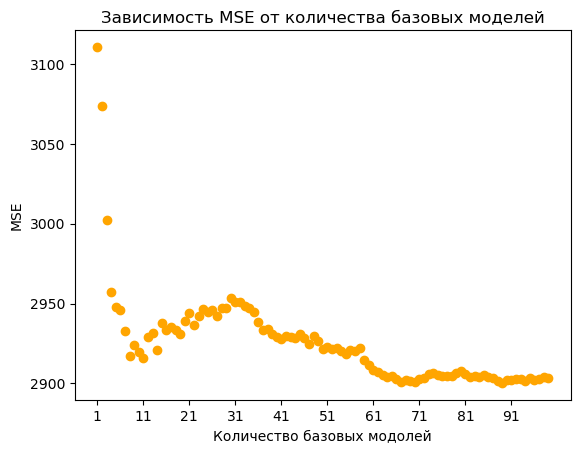

In [24]:
plt.title('Зависимость MSE от количества базовых моделей')
plt.scatter(n_estimators_sklearn, mse_sklearn_list, color='orange')
plt.xlabel('Количество базовых модолей')
plt.ylabel('MSE')
plt.xticks([i for i in range(1, 100, 10)])
plt.show()